<div style="background-image: url('https://images.unsplash.com/photo-1496886077455-6e206da90837?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=500&q=60'); background-size: 40%; background-repeat: no-repeat; background-position: right;">

# Shifted Rosenbrock’s Function

$F_3(x) = \sum_{i=1}^{D-1}(100(z_i^2 - z_{i+1})^2+(z_i-1)^2) + f_{bias_3}$, 
    
$ z = x - o $, $x = [x_1,x_2,...,x_D]$

D: dimensions. $o = [o_1, o_2, ..., o_D]$ : the shifted global optimum.

### Properties:
- Multi-modal
- Shifted
- Non-separable
- Scalable
- Having a very narrow valley from local optimum to global optimum
- Dimension D as 100, 500 and 1000
- $x∈[−100,100]^D$ , Global optimum: $x^* = o$ , $F_3(x^*) = f_{bias_3} = 390$
    </div>

In [1]:
import sys
sys.path.append('../') # just to allow using python files at another directory

import numpy as np
from shifted_go import * # shifted global optimum of the functions
from algorithms import * # optimization algorithms customized
from utils import * # functions used to summarise the results

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import pygmo as pg # package with the optimization algorithms
import time
import pandas as pd

## I. Defining the class for the optimization algorithm
<hr>

In [2]:
class shifted_rosenbrock:
    
    def __init__(self, dim):
        self.dim = dim
        self.name = 'shifted Rosenbrock'

    def fitness(self, x):
        z = np.array(x)
        if z.ndim <= 1:
            z = z - rosenbrock[:len(z)]
            z = np.sum(100*(z[:-1]**2-z[1:])**2 + (z[:-1]-1)**2)
        else:
            z = z - rosenbrock[:z.shape[1]]
            z = np.sum(100*(z[:,:-1]**2-z[:,1:])**2 + (z[:,:-1]-1)**2,axis=1)
        return [z + f_bias[2]]
    
    def get_bounds(self):
        return ([-100]*self.dim,[100]*self.dim)
    
    def get_nic(self): # number of inequality constraints
        return 0
    
    def get_nec(self): # number of equality constraints
        return 0
    
    def get_name(self): # number of equality constraints
        return self.name + ' - dimension ' + str(self.dim)
    
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)

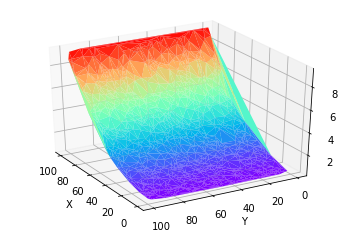

In [3]:
grid = 100*np.random.rand(1000, 2)
function = shifted_rosenbrock(2)
z = function.fitness(grid)
ax = plt.axes(projection='3d')

ax.plot_trisurf(grid[:,0], grid[:,1], np.array(z).flatten(), cmap='rainbow', linewidth=1)
ax.view_init(30, -210)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# II. Optimizing the function using metaheuristics

<hr>

## II.1 Dimension = 50 

Based on the key point that CMA-ES can improve the performance of non-separable problems and that it is the stateof-the-art in continuous domain evolutionary algorithm we are going to use it on the shifted Rosenbrock optimization.

### Parameters selection

Once PyGMO provides a version of CMA-ES that optimizes the parameters cc, cs, c1, cmu and sigma and it's results are good when compared to manually selection, we are going to use the default values. We are going to evaluate the number of generations and the population size.

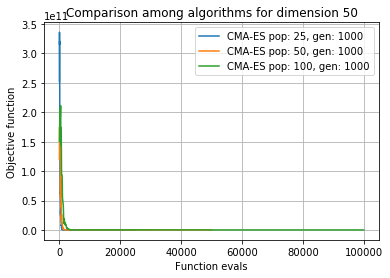

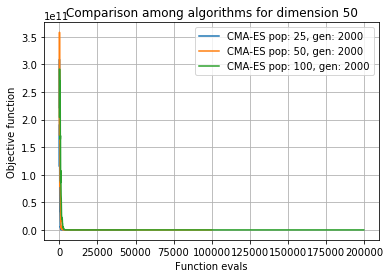

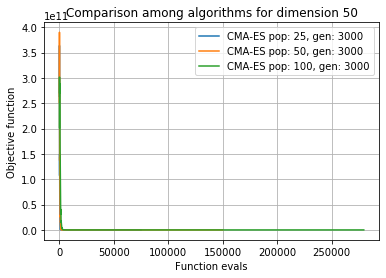

In [4]:
prob = pg.problem(shifted_rosenbrock(50))
stats = []

populations = [25, 50, 100, 25, 50, 100, 25, 50, 100]
generations = [1000, 1000, 1000, 2000, 2000, 2000, 3000, 3000, 3000]
ctr = ''

fig = plt.figure()
for gen, pop_size in zip(generations, populations): 
    logs = []
    best = []
    evals = []
    start_time = time.time()
    
    algo = pg.algorithm(pg.cmaes(gen=gen, cc=-1, cs=-1, c1=-1, cmu=-1, sigma0=.5, ftol=1e-9, 
            xtol=1e-9, memory=False, force_bounds=True))
    algo.set_verbosity(1) # regulates both screen and log verbosity
    pop = pg.population(prob, pop_size)
    sol = algo.evolve(pop)
    logs.append(algo.extract(pg.cmaes).get_log())
    best.append(sol.champion_f)
    evals.append(sol.problem.get_fevals())
    
    end_time = time.time()
    logs = np.array(logs)
    stats.append(['population: '+ str(pop_size) + ', generations: '+str(gen), (end_time-start_time)/25, np.mean(np.array(evals)), np.max(np.array(best)), 
                    np.min(np.array(best)), np.mean(np.array(best)), np.median(np.array(best))])
    avg_log = np.average(logs,0)
    plt.plot(avg_log[:,1],avg_log[:,2] , label=algo.get_name().split(':')[0] + ' pop: '+ str(pop_size) + ', gen: '+str(gen))
    if ctr == '':
        ctr = gen
    elif pop_size ==100:
        ctr = gen
        plt.title('Comparison among algorithms for dimension ' + str(prob.get_nx()))
        plt.xlabel('Function evals')
        plt.ylabel('Objective function')
        plt.legend() 
        plt.grid() 
        plt.show()

In [5]:
df_stats = pd.DataFrame(stats, columns=['parameters', 'avg computational time (sec)', 'avg function evals' , 
                                        'max', 'min', 'avg', 'median'])
df_stats

,parameters,avg computational time (sec),avg function evals,max,min,avg,median
0,"population: 25, generations: 1000",0.205815,25025.0,429.171570,429.171570,429.171570,429.171570
1,"population: 50, generations: 1000",0.365994,50050.0,531.725486,531.725486,531.725486,531.725486
2,"population: 100, generations: 1000",0.689487,100100.0,491.531899,491.531899,491.531899,491.531899
3,"population: 25, generations: 2000",0.423334,50025.0,416.043515,416.043515,416.043515,416.043515
4,"population: 50, generations: 2000",0.784605,100050.0,409.228658,409.228658,409.228658,409.228658
5,"population: 100, generations: 2000",1.607764,200100.0,401.642267,401.642267,401.642267,401.642267
6,"population: 25, generations: 3000",0.718625,75025.0,411.990692,411.990692,411.990692,411.990692
7,"population: 50, generations: 3000",1.320116,150050.0,393.986660,393.986660,393.986660,393.986660
8,"population: 100, generations: 3000",2.057772,279700.0,390.000000,390.000000,390.000000,390.000000


This function is complex, and requires a high number of iterations to converge to the global minimum.

Number of function evaluations:  6845000.0
Final solution vector:  [-74.42752943 -34.7316992  -56.59564936  39.90983676  53.24768271
 -29.3610294   51.69081041  50.79866482 -70.15513784 -29.78367092
 -42.00095411 -19.08812406  72.527249    49.01996305 -45.02768848
  -7.16344367 -39.97564448 -12.8273576   36.81657761  58.13779165
  59.58538267 -16.41231844  28.28778552 -61.56236445 -27.81692881
 -85.52864105  49.29261291  -6.58193912 -81.15964209 -71.078874
  83.24636946  20.58464199 -44.58574384  78.31349386 -11.61296467
 -80.1844606   73.87815558  87.08218239  29.40064724  41.85306362
  -1.04659521  34.44087331 -23.67058736 -16.82064429   3.58349436
 -80.80818566  89.44455472 -33.2703348  -42.83507372  20.81870969]
Fitness:  [390.0000003]
Wall time: 22min 15s


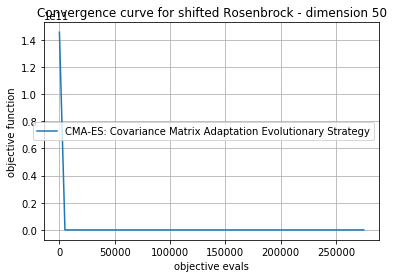

In [6]:
%%time
best = []
fevals = 0
for i in range(25):
    sol = cmaes(shifted_rosenbrock(50), gen=3000, cc=-1, cs=-1, c1=-1, cmu=-1, sigma0=.5, ftol=1e-06, 
            xtol=1e-09, memory=False, force_bounds=True, pop_size = 100)
    if best == [] or sol['champion solution'] < best['champion solution']:
        best = sol    
    fevals += sol['log'][-1][0]

report_convergence(best, fevals)

<hr>

## II.2 Dimension = 500

As CMA-ES is not time performing for higher dimensions and the Rosenbrock is a complex function the algorithm used to optimize it will be the self adaptive differential evolution (SADE).

### Parameters selection

As it is a complex function a huge number of generations is needed to find the best solution, we also need to check how the population size improves the performance at different configurations. We've done some experiments as shown below:

In [88]:
prob = pg.problem(shifted_rosenbrock(500))
stats = []

generations = [1000, 5000, 10000, 20000, 30000, 50000, 100000]
pop_size=15


fig = plt.figure()
for gen in generations: 
    logs = []
    best = []
    evals = []
    start_time = time.time()
    algo = pg.algorithm(pg.de1220(gen=gen, allowed_variants=[11], variant_adptv=1, 
                                       ftol=1e-01, xtol=1e-01))
    algo.set_verbosity(1) # regulates both screen and log verbosity
    pop = pg.population(prob, pop_size)
    sol = algo.evolve(pop)
    logs.append(algo.extract(pg.de1220).get_log())
    best.append(sol.champion_f)
    evals.append(sol.problem.get_fevals())
    
    end_time = time.time()
    logs = np.array(logs)
    stats.append(['generations: '+str(gen), (end_time-start_time)/25, np.mean(np.array(evals)), np.max(np.array(best)), 
                    np.min(np.array(best)), np.mean(np.array(best)), np.median(np.array(best))])

<Figure size 432x288 with 0 Axes>

In [89]:
df_stats = pd.DataFrame(stats, columns=['parameters', 'avg computational time (sec)', 'avg function evals' , 
                                        'max', 'min', 'avg', 'median'])
df_stats

,parameters,avg computational time (sec),avg function evals,max,min,avg,median
0,generations: 1000,0.083771,15015.0,2.229326e+11,2.229326e+11,2.229326e+11,2.229326e+11
1,generations: 5000,0.352159,75015.0,1.040076e+07,1.040076e+07,1.040076e+07,1.040076e+07
2,generations: 10000,0.750483,150015.0,4.296600e+03,4.296600e+03,4.296600e+03,4.296600e+03
3,generations: 20000,1.626709,300015.0,9.211847e+02,9.211847e+02,9.211847e+02,9.211847e+02
4,generations: 30000,2.446578,450015.0,9.750270e+02,9.750270e+02,9.750270e+02,9.750270e+02
5,generations: 50000,2.341794,436710.0,9.339846e+02,9.339846e+02,9.339846e+02,9.339846e+02
6,generations: 100000,3.966867,796230.0,8.655001e+02,8.655001e+02,8.655001e+02,8.655001e+02


Around 10000 generations the algorithm reaches a plateau, and it's difficult to reach the minimum either increasing the population or the number of generations.

Number of function evaluations:  748775.0
Final solution vector:  [-74.44066188 -34.75811648 -56.64713552  39.82465685  53.08018272
 -29.66582815  51.17130115  50.02936935 -71.13909601 -30.77318906
 -42.99067207 -20.0778019   71.53749417  48.03017956 -46.01754196
  -8.15323621 -40.96540123 -13.81713296  35.82677758  57.1479893
  58.59559816 -17.40211085  27.29798934 -62.55215912 -28.80671881
 -86.5184234   48.30282711  -7.57172638 -82.14943037 -72.06866291
  82.25658288  19.59484814 -45.57553569  77.32370655 -12.60275456
 -81.17425309  72.88836703  86.09238891  28.41086003  40.86327575
  -2.03638409  33.45107855 -24.66038656 -17.81044203   2.59369783
 -81.79798756  88.45475443 -34.26015404 -43.82492292  19.82880789
  -9.53289092 -14.67076589 -15.85824907  38.54039798 -71.48975011
 -21.55879694  45.45129899 -63.13910865  28.9690436  -47.34003175
  40.98050679 -43.45399627  -5.47787665  64.36281813  60.02452848
  -4.31392372 -28.76557417   7.60875433  11.08069362  76.54939891
 -40.599103

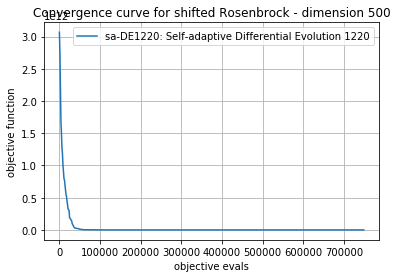

In [90]:
%%time
sol = sade(shifted_rosenbrock(500), gen=30000, allowed_variants=[11], variant_adptv=1, ftol=1e-1, xtol=1e-1, 
           pop_size=25)
report_convergence(sol)